# Extracting subregions from a MUSE cube

I want to learn how to extract regions along the spatial and wavelength axes and manipulate them to do things continuum subtraction.

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))
cube.info()

[INFO] 3801 x 326 x 346 Cube (/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/ADP.2017-10-16T11_04_19.247.fits)
[INFO] .data(3801 x 326 x 346) (1e-20 erg / (Angstrom cm2 s)), .var(3801 x 326 x 346)
[INFO] center:(-72:10:31.853,00:59:02.986) size:(65.200",69.200") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:4599.94 max:9349.94 step:1.25 Angstrom


## Extracting wavelength slices

We make a summed spectrum of the entire field again, just like in the previous notebook.

In [3]:
sp0 = cube.sum(axis=(1, 2))

Now, we take a look at the region around the H alpha line. The `Spectrum.subspec` method allows us to use Å instead of pixels.

[None]

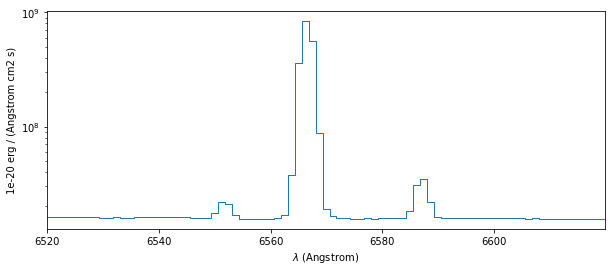

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(6520.0, 6620.0).plot()
ax.set(yscale="log")

This shows that a good range for extracting Ha would be 6560 to 6575 Å.  So, we just do a simple-minded sum of that range. For some reason, the equivalent of `Spectrum.subspec` for a `Cube` has a different name, `Cube.select_lambda`:

In [93]:
im_ha = cube.select_lambda(6560.0, 6575.0).sum(axis=0)

And we have a look at it:

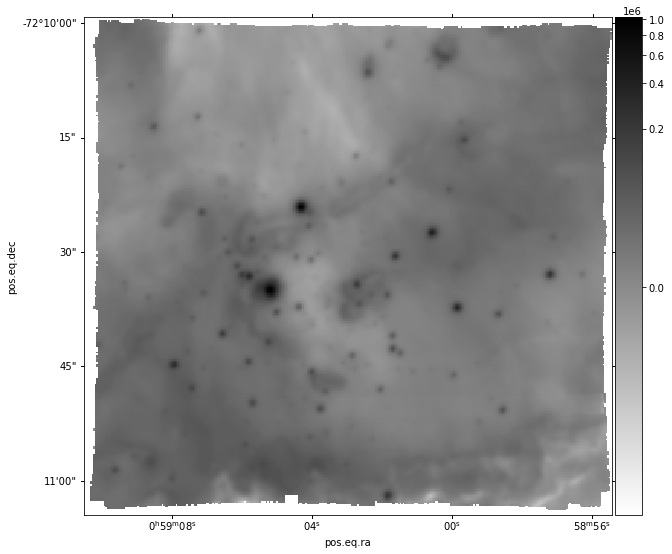

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha.plot(use_wcs=True, cmap="gray_r", scale="log", colorbar="v")

So, that looks good, but it includes the continuum.  A very simple-minded way of removing the continuum would just be to take an average value in line-free wavelength ranges.

We can use 6555-60 and 6575-80:

In [95]:
im_blue_cont = cube.select_lambda(6555.0, 6560.0).mean(axis=0)
im_red_cont = cube.select_lambda(6575.0, 6580.0).mean(axis=0)
im_mean_cont = (im_blue_cont + im_red_cont) / 2.0

So we have a map of the average continuum from the red and blue sides of the line, which we will now visualize:

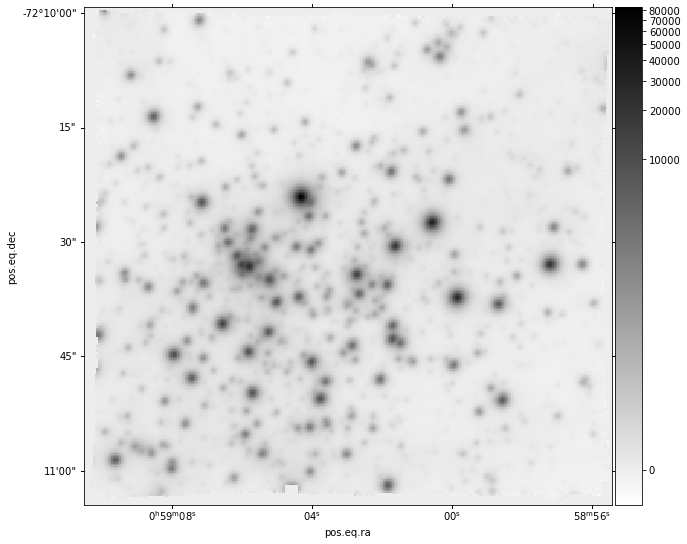

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))
im_mean_cont.plot(use_wcs=True, cmap="gray_r", scale="log", colorbar="v")

Now I subtract the average continuum level before summing again to find the BG-subtracted line map. We have to do it this way because `im_mean_cont` still has the per-Å units since it is a mean, so we can't just subtract it from `im_ha`.

In [97]:
im_ha_bgsub = (cube.select_lambda(6560.0, 6575.0) - im_mean_cont).sum(axis=0)

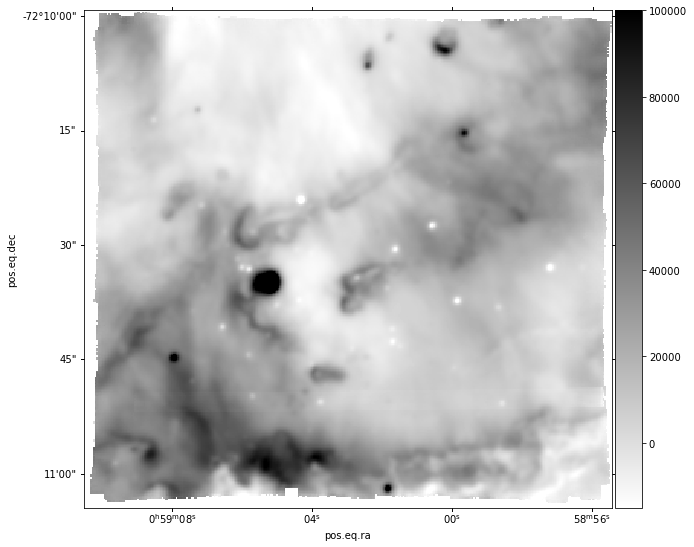

In [315]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha_bgsub.plot(
    use_wcs=True,
    vmin=-1.5e4,
    vmax=1.0e5,
    cmap="gray_r",
    scale="linear",
    colorbar="v",
)

So. now we can see beautiful details of the Hα emission. There are chains of globules and elephant-trunk structures that cross the nebula. These are physically quite large – about 2 arcsec, which is about 0.5 parsec.  The entire field is about 15 pc square.

The white dots are presumably from the underlying photospheric absorption from some of the stars.  Other stars are seen in emission.

*Note that the `Cube.get_image()` function can do the continuum subtraction semi-automatically, which may be more convenient in some instances.*

Strangely, though, the brightnesses go negative

In [99]:
im_ha.data.min()

-23906.358207702637

Look at a restricted region at the top of the map to avoid most of the stars

In [322]:
im_ha_floor = np.min(im_ha[300:, 50:70].data)
im_ha_floor

-17154.428394317627

In [323]:
im_cont_floor = np.min(im_mean_cont[-100:, 100:150].data)
im_cont_floor

-33.236980128288266

This seems to be due to over-subtraction of a sky spectrum.  We will try and deal with this properly later.

### Calculate the H alpha equivalent width

In wavelength units, the emission line EW is
$$
W_\lambda = \int \frac{F_\lambda - F_c}{F_c} \, d\lambda
$$


In [324]:
wav_pix = cube.get_step()[0]
im_ha_ew = wav_pix * (
    (im_ha_bgsub - im_ha_floor) / (im_mean_cont - im_cont_floor) - 1.0
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: divide by zero encountered in true_divide
  var /= (b_data ** 4)


To deal with the negative pixels, we just add on the estimated floow value of both the line map and the continuum map.

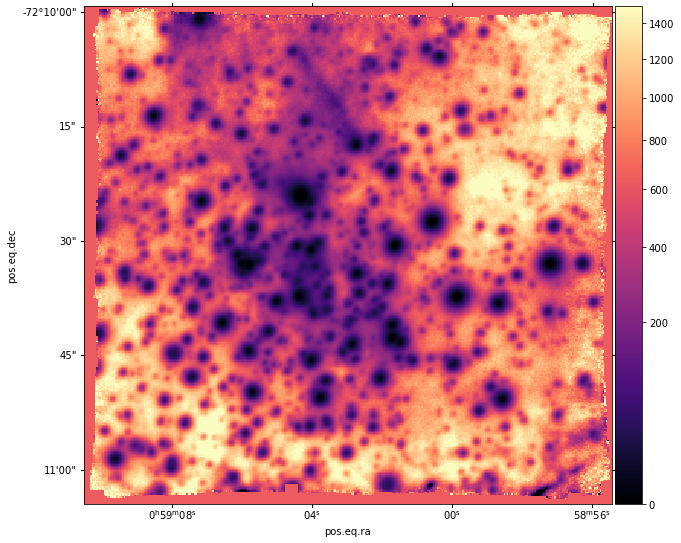

In [325]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha_ew.plot(
    vmin=0.0,
    vmax=1500.0,
    use_wcs=True,
    cmap="magma",
    scale="sqrt",
    colorbar="v",
)

 ## Extracting spatial regions

### Masking of 2D images

We will go back to the ha+continuum image and try and plot it without the stars

In [103]:
savemask = im_ha.mask.copy()
savemask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

We mask out the bright continuum sources using `mask_selection`

In [104]:
im_ha.mask_selection(np.where(im_mean_cont.data > 1000.0))

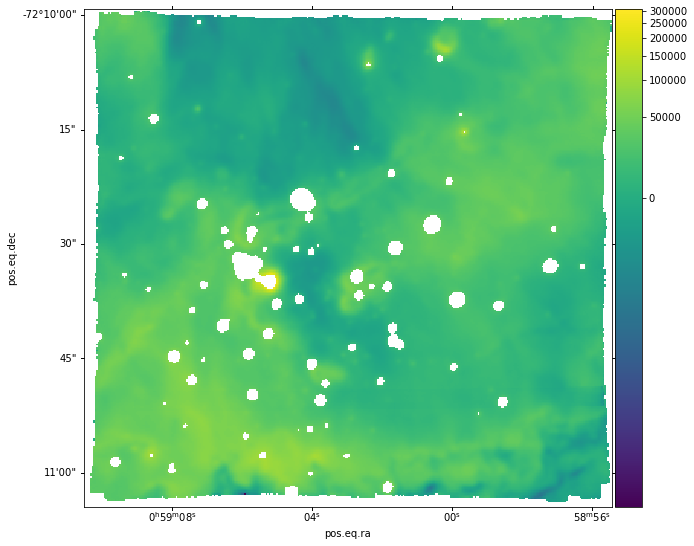

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))
im_ha.plot(use_wcs=True, cmap="viridis", scale="log", colorbar="v")

What this uses is an array of pixels, such as provided by `np.where`:

In [106]:
bright_cont_selection = np.where(im_mean_cont.data > 1000.0)
bright_cont_selection

(array([  9,   9,  10, ..., 318, 323, 323]),
 array([198, 199, 196, ...,  76,  13,  14]))

### Masking of a 3D cube (small subcube version)

My first attempts at doing this did not work as I expected, so I am going to extract a small sub-cube that will be easy to look at.

There are at least three ways that look like they might be used to make a sub-cube:

1. `Cube.subcube(center=..., size=..., lbda=..., ...)` cuts out a rectangle.  It returns a view so we would have to do `.copy()`
2. `Cube.truncate(coord=[w1, x1, y1, w2, x2, y2], ...)` does return a copy, and with a slightly different interface
3. `Cube[k1:k2, j1:j2, i1:i2]` is the simplest approach using pixel slice notation, and should return a copy

We will try the third way first, but just for the celestial coordinates, then use `.select_lambda()` to extract a small section of the wavelength axis:

In [22]:
cc = cube[:, 5:15, 130:140].select_lambda(6554.0, 6581.0)

In [23]:
cc.info()

[INFO] 22 x 10 x 10 Cube (/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/ADP.2017-10-16T11_04_19.247.fits)
[INFO] .data(22 x 10 x 10) (1e-20 erg / (Angstrom cm2 s)), .var(22 x 10 x 10)
[INFO] center:(-72:11:02.4527,00:59:04.6418) size:(2.000",2.000") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:6553.69 max:6579.94 step:1.25 Angstrom


We have a 10x10 pixel postage stamp, with 22 pixels in wavelength. Some of the pixels are from the image border and are masked, as we can see here:

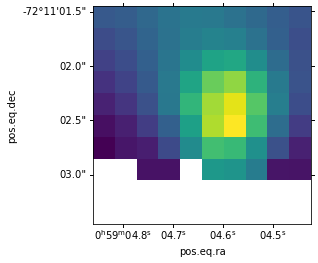

In [24]:
cc.sum(axis=0).plot(use_wcs=True)

I chose this region because it contains a star that we can try and mask out.  Here is the spectrum averaged over all pixels and plotted on a linear scale:

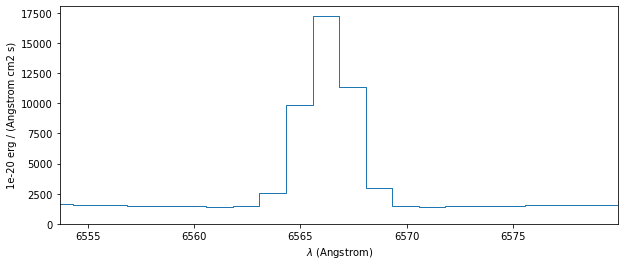

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
cc.mean(axis=(1, 2)).plot()
ax.set(ylim=[0, None])

So, we have roughly equal parts continuum and line emission.

Now, we look at the mask (steps by multiple pixels so we can see it better):

In [26]:
cc.mask[::5, ::2, ::2]

array([[[ True,  True,  True,  True,  True],
        [ True, False,  True, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True, False, False],
  

We see a stack of wavelength images. Each has y-axis inverted, so the `True` values in each top row are the bottom line of pixels in each image.

I am going to try and mask the pixels that have relatively strong continuum, and then recalculate the average spectrum.  With luck, that will make the line stand out more.  First, save the original mask (I use copy here because otherwise they are just different views of the same object - we should also use copy to put the original mask back if we ever want to).

In [27]:
cc_mask_orig = cc.mask

In [28]:
id(cc_mask_orig), id(cc.mask)

(140642613863248, 140642613863248)

In [29]:
cc_mask_orig = cc.mask.copy()

In [30]:
id(cc_mask_orig), id(cc.mask)

(140642876925552, 140642613863248)

#### Masking via simple slicing on the celestial pixel axes

First, I try doing it by hand with pixel slicing of the mask.  I will attempt to mask out the bottom right of the cube (8x8 pixels), so we just leave a 2 pixel L-shaped strip:

In [31]:
cc.mask[:, :8, -8:] = True

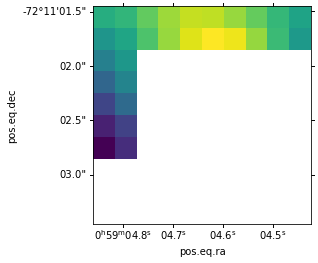

In [32]:
cc.sum(axis=0).plot(use_wcs=True)

So that looks OK. Now I check if it has had any effect on the average spectrum:

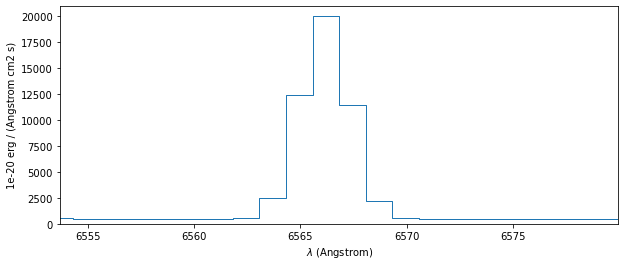

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))
cc.mean(axis=(1, 2)).plot()
ax.set(ylim=[0, None])

Yes, the continuum level is now much lower, although this is at a cost of removing most of the pixels.

#### Masking via logical operation to make a boolean array

Now, we will see if we can use a logical condition to set the mask.  But first, restore the original

In [84]:
cc.mask = cc_mask_orig.copy()

We can make a 2D mask, which is true for all pixels where the continuum intensity is more than half the average intensity in the passband:

In [85]:
my_mask = cc[:6, :, :].mean(axis=0).data > 0.5 * cc.mean(axis=0).data

Note that we had to extract the `.data` before comparing, otherwise we get something very strange.  Even so, the mask we get back is itself a masked array – so it is a masked mask!

In [86]:
my_mask[::2, ::2]

masked_array(
  data=[[--, --, --, --, --],
        [--, False, --, True, False],
        [False, False, True, True, True],
        [False, False, True, True, True],
        [False, False, False, False, False]],
  mask=[[ True,  True,  True,  True,  True],
        [ True, False,  True, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],
  fill_value=True)

The `.data` part has a logical array where our condition is true.  The `.mask` part is another logical array where the cube's mask is true.  We can simplify life by just ORing them together to make a simple array:

In [87]:
my_mask = my_mask.mask | my_mask.data
my_mask[::2, ::2]

array([[ True,  True,  True,  True,  True],
       [ True, False,  True,  True, False],
       [False, False,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False, False, False]])

In order to apply this mask to the cube, we need to make it 3-dimensional:

In [88]:
my_mask_3d = np.repeat(my_mask[None, :, :], cc.shape[0], axis=0)

In [89]:
my_mask_3d[::5, ::2, ::2]

array([[[ True,  True,  True,  True,  True],
        [ True, False,  True,  True, False],
        [False, False,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True,  True, False],
        [False, False,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True,  True, False],
        [False, False,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True,  True, False],
        [False, False,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False, False, False]],

       [[ True,  True,  True,  True,  True],
        [ True, False,  True,  True, False],
  

Now directly set the cube's mask to be this boolean array.

In [90]:
cc.mask = my_mask_3d.copy()

Have a look at the result. First collapse the spectral axis to make an image:

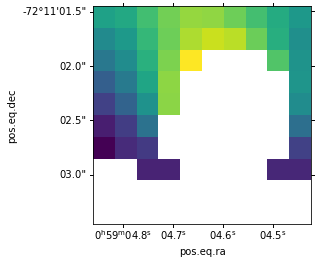

In [107]:
cc.sum(axis=0).plot(use_wcs=True)

Looks good.  We see that the original border is still masked, plus a roughly circular patch around the star.

Now collapse the celestial axes to get a spectrum, which should be of the unmasked pixels only:

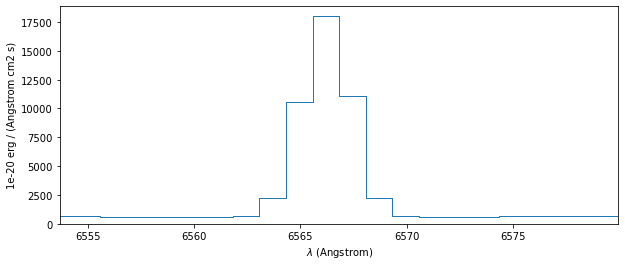

In [92]:
fig, ax = plt.subplots(figsize=(10, 4))
cc.mean(axis=(1, 2)).plot()
ax.set(ylim=[0, None])

Yep. that looks fine.

### Masking of a 3D cube (big cube version)

Now that I have a method that seems to work, I will go back to the full cube and try things there.  Although, I will restrict it to the an extended wavelength range around H alpha. We will use the range 6200 to 6800 Å, which is the same as Fig 3 of my Raman paper.

In [349]:
hacube = cube.select_lambda(6200.0, 6800.0)
hacube.info()

[INFO] 481 x 326 x 346 Cube (/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/ADP.2017-10-16T11_04_19.247.fits)
[INFO] .data(481 x 326 x 346) (1e-20 erg / (Angstrom cm2 s)), .var(481 x 326 x 346)
[INFO] center:(-72:10:31.853,00:59:02.986) size:(65.200",69.200") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:6199.94 max:6799.94 step:1.25 Angstrom


Save a copy of the original mask again

In [350]:
hacube_mask_orig = hacube.mask.copy()

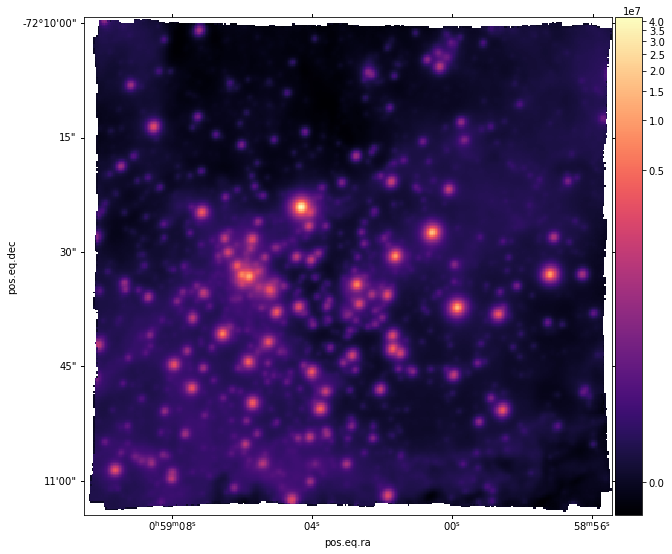

In [351]:
fig, ax = plt.subplots(figsize=(10, 10))
hacube.sum(axis=0).plot(use_wcs=True, cmap="magma", scale="log", colorbar="v")

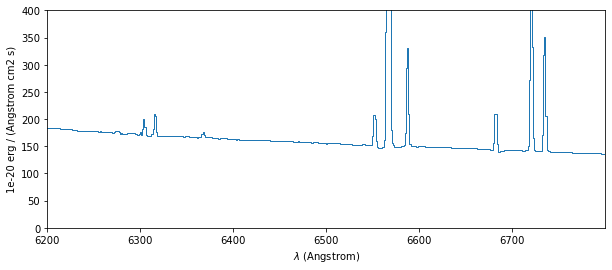

In [352]:
fig, ax = plt.subplots(figsize=(10, 4))
haspec_allpix = hacube.mean(axis=(1, 2))
haspec_allpix.plot()
ax.set(ylim=[0, 400])

There really is a lot of continuum here.  It would be good to get rid of some of it so we can see the lines better!


We will take an aggressive approach to try and mask out all the stars by taking an EW threshold of 750 Å.

In [360]:
ew_mask = (im_ha_ew.data < 750.0) | im_ha.mask
nmask = ew_mask.data.sum()
npix = np.prod(ew_mask.shape)
print("Number of masked pixels:", nmask)
print("Fraction of masked pixels:", nmask / npix)

Number of masked pixels: 72671
Fraction of masked pixels: 0.6442693003297989


So that has eliminated more than half of the pixels. Let's see if it was worth it.

Make a 3D mask for `hacube` by repeating multiple copies of this 2D mask along the wavelength axis:

In [354]:
my_mask_3d = np.repeat(
    ew_mask.data[None, :, :],
    hacube.shape[0],
    axis=0,
)

Have a look at a sparse sample of the cube mask:

In [355]:
my_mask_3d[:2, ::20, ::50]

array([[[ True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False, False],
        [ True,  True,  True, False,  True, False, False],
        [ True, False, False,  True,  True, False, False],
        [ True, False,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True, False],
        [ True, False,  True,  True,  True, False,  True],
        [ True, False,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True, False],
        [ True, False,  True,  True,  True, False, False],
        [ True, False,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False,  True, False

Looks OK. Now we apply it to the cube.  We need to make sure we are also masking out the voxels that were originally masked, since some of them have invalid data, which can cause problems with the spectra.

In [356]:
hacube.mask = my_mask_3d.copy() | hacube_mask_orig

And redo the summed image and average spectrum:

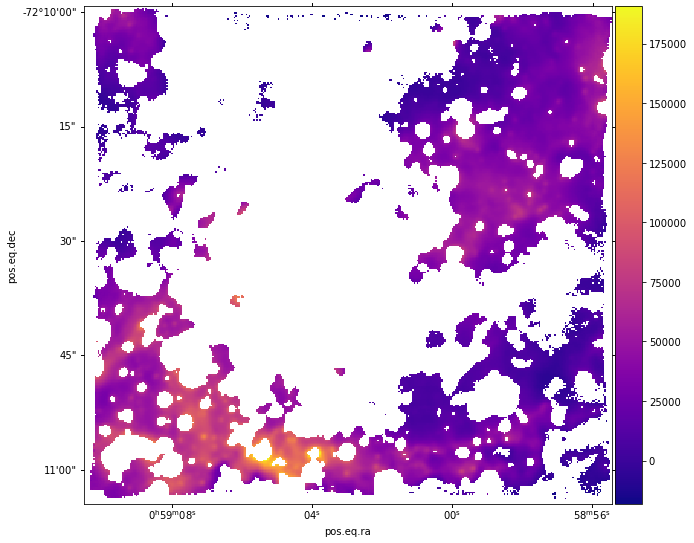

In [361]:
fig, ax = plt.subplots(figsize=(10, 10))
hacube.sum(axis=0).plot(use_wcs=True, cmap="plasma", scale="linear", colorbar="v")

There are lots of white patches there, where we have eliminated the broad PSFs of the bright stars.  What remains should be mostly nebulosity.

Now we can compare the total spectrum with what we had earlier:

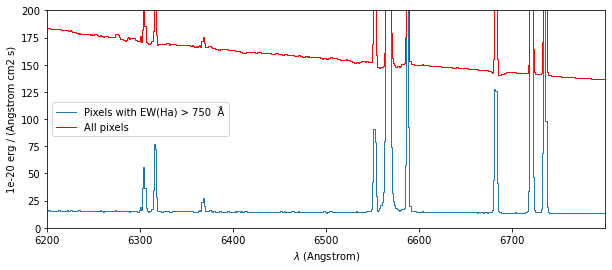

In [363]:
fig, ax = plt.subplots(figsize=(10, 4))
hacube.mean(axis=(1, 2)).plot(label="Pixels with EW(Ha) > 750  Å")
haspec_allpix.plot(c="r", label="All pixels")
ax.legend()
ax.set(ylim=[0, 200])

Comparing the red line (all pixels) and the blue line (unmasked pixels only), we can see that we have eliminate 90% of the continuum by masking out the stars.  We have also managed to remove most of the underlying photospheric absorption lines.  This is most obvious in the He I 6678 line, but can also be seen in H alpha.

### Investigating the over-subtracted sky

I consentrate on the slice `[-30:, 50:70]` since that seems to be one of the worst-affected regions.

[(-100.0, 20.0)]

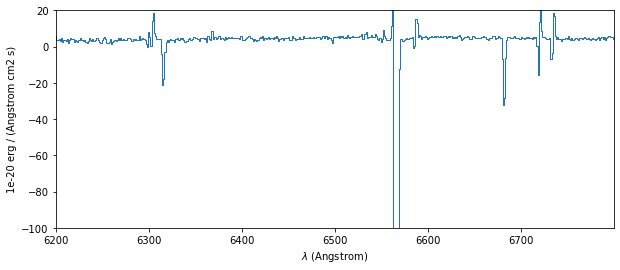

In [252]:
hacube.mask = hacube_mask_orig.copy()
fig, ax = plt.subplots(figsize=(10, 4))
hacube[:, -30:, 50:70].mean(axis=(1, 2)).plot()
ax.set(ylim=[-100, 20])

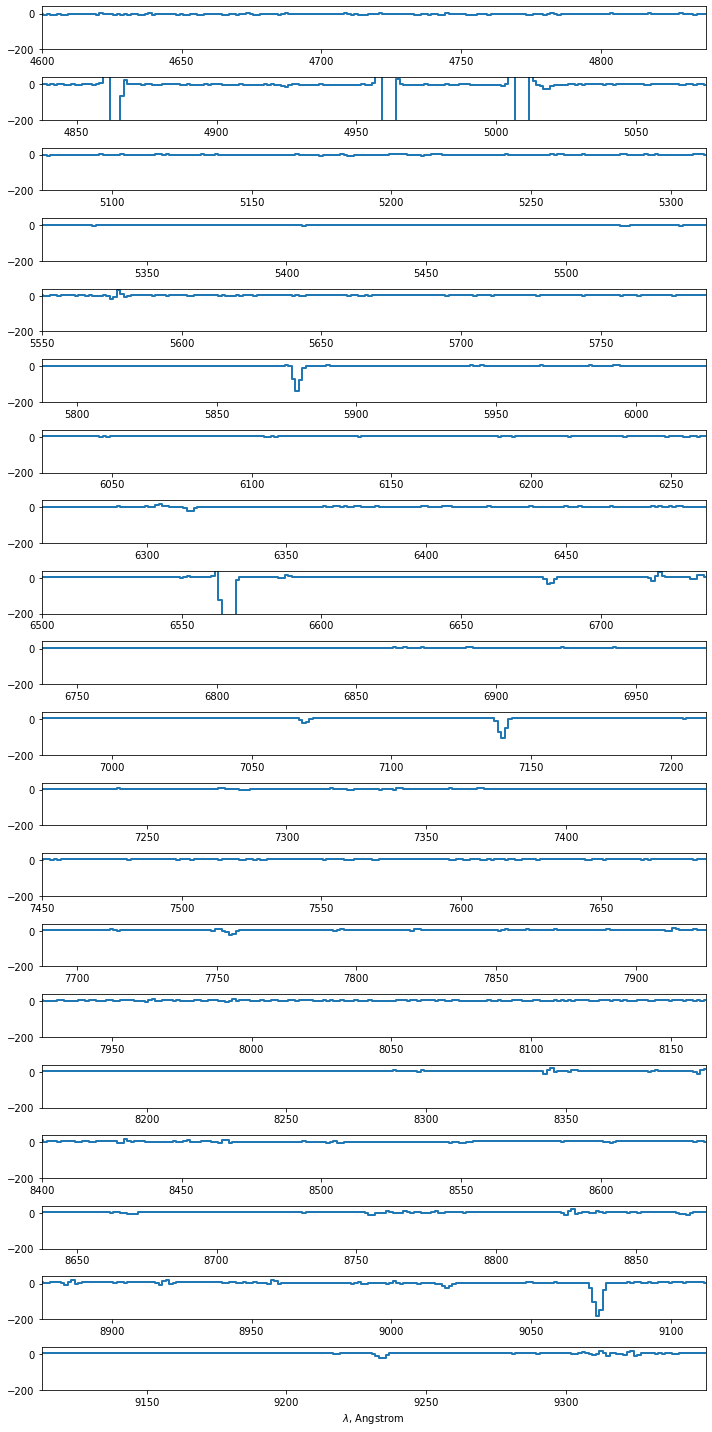

In [280]:
nspec = 20
wavmin, _, _, wavmax, _, _ = cube.get_range()
dwav = (wavmax - wavmin) / nspec
fig, axes = plt.subplots(nspec, 1, figsize=(10, 1.0 * nspec))
wav1 = wavmin - dwav
wav2 = wavmin
for ax in axes:
    wav1 += dwav
    wav2 += dwav
    spec = cube[:, -30:, 50:70].select_lambda(wav1, wav2).mean(axis=(1, 2))
    spec.plot(ax=ax, linewidth=2)
    ax.set(ylim=[-200, 40], ylabel="", xlabel="")
axes[-1].set(xlabel=r"$\lambda$, Angstrom")
fig.tight_layout()